# Bootstrap в статистике

Основная идея этого метода достаточно проста - мы делаем многократные "выборки из выборки" для получения лучшего представляения о генеральной совокупности, чем при использовании одной единственной выборки. Допустим, в розничной сети магазинов мы провели эксперимент, проверяющий гипотезу о том, что, вопреки расхожему мнению, расположение хлеба прямо у входа ведет к увеличению выручки. Наши данные вряд ли будут нормально распределены, а статистические тесты вполне могут дать противоречивые результаты (например, предпосылки для t-test не выполнены, а мощность манна-уитни нас не устраивает). Очевидно, в идеальном мире мы бы хотели повторить этот тест, например, 10000 раз и посмотреть на распределение результатов. Не менее очевилно, что в реальной жизни это решительно невозможно.

Тут-то нам на помощь и приходит бутстрэп. Мы просто берем нашу полученную в результате эксперимента выборку размера n и делаем из нее много выборок с повторением (не обязательно того же размера), в каждой из которых замеряем искомую статистику (будь то среднее, медиана, куртозис или какой-то определенный квантиль). Иными словами из выборки (1,2,3) мы можем получить бутстрэп-выборку (1,2,2) или (3,3,3) и т.д. Повторив эту процедуру большое кол-во раз (чем больше, тем лучше, часто предлагают от 1000 до 10000), мы, очевидно, получим бутстрэп-распределение искомой статистики. Одним из полезных на практике преимуществ такого подхода является возможность построить доверительные интервалы для медианы, чего ЦПТ сделать не дает.

*ОЧЕНЬ* важно понимать, что бутстрэп - не панацея. Он может дать неплохие результаты, только если мы уверены в том, что наша выборка является репрезентативной, то бишь хорошо отражает генеральную совокупность. Кроме того, в случае с постоянно идущими/динамическими тестами/биг датой бутстрэп будет занимать существенное время. На практике, как правило, чтобы выбрать лучший метод, сначала гоняют симуляции на уже существующих данных, чтобы посмотреть, как себя на них показывает т-тест, манн-уитни и т.д. и уже на основании этих симуляций сделать выбор.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.stats import sem
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from typing import List

from tqdm.auto import tqdm  #это нарисует прогресс бар
import seaborn as sns

plt.style.use('ggplot')

<a id='code'></a>

In [2]:
class Bootstrap():
    def _pure_bootstrap(
        self,
        data,
        statistic,
        num_iterations,
    ):
        """
        Performs resampling of the data, computes statistic of choice.

        Parameters:
        data(array_like): The "initial" sample to be used as a source for bootstraping samples. 
        statistic(callable): the statistic to be calculated for each resample.
        num_iterations(int), optional: number of times the resampling procedure will be performed. 1000 by default.
        conf_level(float), optional: confidence level (e.g. for a 5% Type 1 error conf_level will be 0.95)

        Returns:
        numpy ndarray of length=num_iterations containing the desired statistic values
        """
        sample_size = len(data)

        boot_data = []
        for i in range(num_iterations):
            col1 = resample(data, n_samples=sample_size, replace=True)
            boot_data.append(statistic(col1))
        return pd.DataFrame(boot_data)

    def _plot_results(self, data: pd.DataFrame, quantile_values, add_zero):
        fig = plt.figure(figsize=(6, 4))
        plot = plt.hist(data[0])
        plt.vlines(quantile_values, ymin=0, ymax=max(plot[0]), linestyle='dashed', linewidth=2, color='black')
        if add_zero:
            plt.axvline(0, linestyle='dashed', linewidth=2, color='royalblue')
            plt.annotate(s='null', xy=[0, max(plot[0])-1])
        plt.show()
        return fig

    def _conf_intervals(self, data: pd.DataFrame, conf_level):
        left = (1-conf_level)/2
        right = 1-left
        return data.quantile([left, right])

    def _bootstrap_attrs(self, data, statistic, num_iterations, conf_level, plot_results, add_zero, test_type, p_values=pd.DataFrame):
        if p_values.empty:
            p_values = self._conf_intervals(data, conf_level)
        plot=None
        if plot_results:
            plot = self._plot_results(data=data, quantile_values=p_values, add_zero=add_zero)
        res = BootstrapResult(statistic=statistic,
        num_iterations=num_iterations,
        test_type=test_type,
        conf_level=conf_level,
        plot_obj=plot,
        conf_intervals=p_values,
        boot_mean = data[0].mean())
        return res

    def _studentized(self, data, num_iterations):
        sample_size = len(data)
        boot_data_t = list()
        boot_data_stat = list()
        sample_mean = np.mean(data)
        for i in range(num_iterations):
            boot_pass = resample(data, n_samples=sample_size, replace=True)
            resample_mean = np.mean(boot_pass)
            se = sem(boot_pass, ddof=0)
            q = (resample_mean - sample_mean)/se
            boot_data_t.append(q)
            boot_data_stat.append(resample_mean)
        return {"t-stat": pd.DataFrame(boot_data_t), "sample_mean": sample_mean, "se": se, "resample_stat": pd.DataFrame(boot_data_stat)}

    def studentized_bootstrap(self, data, num_iterations=10000, conf_level=0.95, plot_results=True):
        boot_res = self._studentized(data, num_iterations)
        test_type = 'studentized bootstrap'
        raw_quantiles = self._conf_intervals(boot_res['t-stat'], conf_level)
        stud_quantiles = pd.DataFrame(boot_res['sample_mean'] - raw_quantiles[0]*boot_res['se'])
        temp1, temp2 = stud_quantiles.iloc[0].copy(), stud_quantiles.iloc[1].copy()
        stud_quantiles.iloc[0], stud_quantiles.iloc[1] = temp2, temp1
        res = self._bootstrap_attrs(boot_res['resample_stat'], np.mean, num_iterations, conf_level, plot_results, add_zero=False, test_type='studentized', p_values = stud_quantiles)
        return res


    def one_sample_bootstrap(self, data, statistic, num_iterations=10000, conf_level=0.95, plot_results=True):
        boot_res=self._pure_bootstrap(data, statistic, num_iterations)
        add_zero = False
        test_type='one_sample'
        res = self._bootstrap_attrs(boot_res, statistic, num_iterations, conf_level, plot_results, add_zero, test_type)
        return res

    def two_sample_bootstrap(self, control, treatment, statistic, num_iterations=10000, conf_level=0.95, plot_results=True):
        boot_1 = self._pure_bootstrap(control, statistic, num_iterations)
        boot_2 = self._pure_bootstrap(treatment, statistic, num_iterations)
        diff = boot_1-boot_2
        add_zero = True
        test_type = 'two-sample'
        res = self._bootstrap_attrs(diff, statistic, num_iterations, conf_level, plot_results, add_zero, test_type)
        return res

class BootstrapResult():
    def __init__(self, statistic, test_type, num_iterations, conf_level, plot_obj, conf_intervals, boot_mean):
        self._statistic = statistic
        self._test_type = test_type
        self._num_iterations = num_iterations
        self._conf_level = conf_level
        self._plot_obj = plot_obj
        self._conf_intervals = conf_intervals
        self._boot_mean = boot_mean

    @property
    def statistic(self):
        print ("test")
        return self._statistic.__name__

    @property
    def test_typr(self):
        return self._test_type

    @property
    def num_iterations(self):
        return self._num_iterations

    @property
    def confidence_lefel(self):
        return self._conf_level

    @property
    def plot_obj(self):
        return self._plot_obj
    
    @property
    def confidence_intervals(self):
        return self._conf_intervals

    @property
    def bootstrap_mean(self):
        return self._boot_mean

    def __str__(self):
        header = f"Bootstrapping results\n\n"
        test_type = f"Test type: {self._test_type}\n"
        test_stat = f"Test statistic: {self._statistic.__name__}\n"
        conf_int = f"Confidence intervals at {self._conf_level} level: {self._conf_intervals[0].iloc[0]:.3f} - {self._conf_intervals[0].iloc[1]:.3f}"
        return header + test_type + test_stat + conf_int


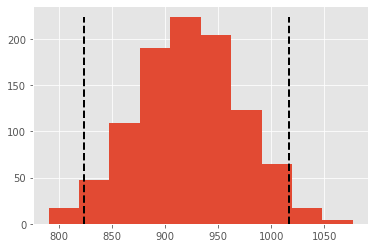

Bootstrapping results

Test type: one_sample
Test statistic: mean
Confidence intervals at 0.95 level: 824.076 - 1016.340


In [79]:
test_data = np.random.exponential(scale=1/0.001, size=300)
test_class = Bootstrap()
res=test_class.one_sample_bootstrap(data=test_data, statistic=np.mean, num_iterations=1000)
print(res)

Есои у нас две выборки и мы тестируем. отличаются ли они друг от друга, бутстрэп тоже может нам помочь. Бутстрэпируем одну выборку, вторую, находим для каждого прохода разницу средних и получаем доверительный интервал. Очевидно, что если ноль не попадает в этот интервал, мы можем откинуть нулевую гипотезу.

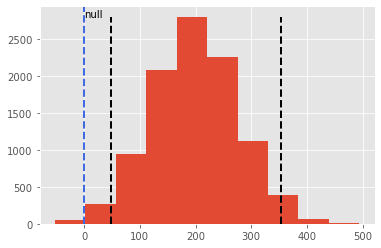

Bootstrapping results

Test type: two-sample
Test statistic: mean
Confidence intervals at 0.95 level: 48.369 - 352.675


In [4]:
test_data_smpl2 = np.random.exponential(scale=1/0.00125, size=350)
res2 = test_class.two_sample_bootstrap(control=test_data, treatment=test_data_smpl2, statistic=np.mean)
print(res2)

Более того, мы не ограничены в кол-ве групп, то бишь нам не обязательно сравнивать между собой всего лишь две группы, чтобы мы могли использовать бутстрэп. Абсолютно по такому же принципу мы можем бутстрэппировать n групп для ANOVA и получить бутстржп распределение F-статистики. Правда тут у нас уже будут не доверительные интервалы, а классическое p-value, т.е. площадь под кривой для всех значений больше, чем F-статистика, полученная на оригинальнйо выборке.

# Бутстрэп Стьюдента (studentized bootstrap)

При всех своих неоспоримых достоинствах, бутстрэп, конечно же, не лишен и недостатков. Во-первых, он не является волшебной палочкой и не может магическим образом обнаружить то, чего нет в основной выборке. Соответственно, если выборка нерепрезентативна, то и бутстрэп покажет себя не лучшим образом. Во-вторых, на небольших выборках (n<100, а некоторые утверждают, что и n<500) он систематически недооценивает доверительные интервалы. Обе эти пробелмы отчасти решаются с ростом размера выборки. Однако не всегда возможно нарастить выборку, именно для таких случаев и придуман бутстрэп Стьюдента.
Сначала наглядно покажем как точность оценки бутстрэппированных доверительных интервалов растет с увеличением размера выборки.

In [5]:
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [46]:
# посчитаем реальную среднюю по всей совокупности и посмотрим сколько раз она попадет в доверительный интервал бутстрэпа
theta = df['price'].mean()
def coverage(bresults: List[BootstrapResult], theta):
    res = np.count_nonzero([i.confidence_intervals[0].iloc[0] < theta < i.confidence_intervals[0].iloc[1] for i in bresults])/len(bresults)
    return res

In [47]:
%%time

test_cov=[]
for n in range(4, 120, 2):
    testsmpl = [np.random.choice(df['price'],replace=False, size=n) for i in range(500)]
    testboot = [test_class.one_sample_bootstrap(i, statistic=np.mean, plot_results=False, num_iterations=1000) for i in testsmpl]
    test_cov.append(coverage(testboot, theta))

Wall time: 23min 44s


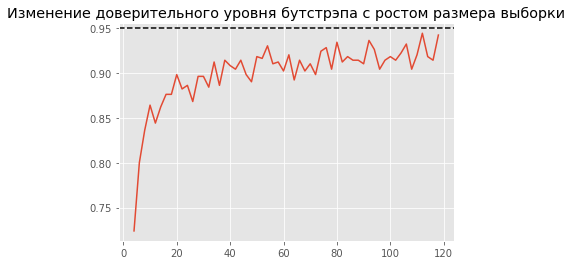

In [48]:
x = np.arange(4,120,2)
plt.plot(x, test_cov)
plt.title('Изменение доверительного уровня бутстрэпа с ростом размера выборки')
#plt.xlabel('Размер выборки')
#plt.ylabel('Доверительная вероятность')
plt.axhline(0.95, linestyle='--', color='black')
plt.show()

Как мы видим, традиционный бутстрэп систематически дает доверительный уровень ниже реального. Очевидно, что чем меньше выборка, тем хуже она аппроксимирует генеральную совокупность, именно поэтому эта проблема частично нивелируется с росто размера выборки. В то же время, у нас не всегда есть возможность заполучить большую выборку. Именно для этих случаев и придуман бутстрэп Стьюдента. Основной его идеей явлется нормализация распределения тестовой статистики так, чтобы оно было центрировано в нуле и имело стандартное отклонение равное 1. Тут стоит отметить, что мы можем это делать только в случае, если наша бутстрэпированная статистика гомоскедастична.

Чтобы понять, в чем смысл этой идеи, еще раз внимательно посмотрим на рез-ты обычного бутстрэпа: мы получаем некий доверительный интервал и рассчитываем, что с некоторой вероятностью, равной нашему доверительному уровню, реальное значение статистики окажется внутри этого интервала.
Если $\large{\theta^*}$ - статистика популяции, $\large{\hat{\theta}}$ - статистика первичной выборки (с которой потом делаем бутстрэп), а $\large{\tilde{\theta}}$ - статистика бутстрэппированной выборки, то для доверительного уровня 95% хотим иметь: $\large{0.95 = P(q_{2.5} \leq \theta^* \leq q_{97.5})}$, но как показывает наша симуляция выше, для маленьких выборок это не особо работает.

Почему так происходит? Дело в том, что у нас есть сразу два источника ошибок. Первый - это предположение о том, что изначальная выборка хорошо аппроксимирует генеральную совокупность, то бишь мы оцениваем $\large{\theta^*}$ с помощью $\large{\hat{\theta}}$. Второй - это наша аппроксимация $\large{\hat{\theta}}$ с помощью $\large{\tilde{\theta}}$. Первую ошибку мы уменьшить не можем, не обладая информацией о статистике по генеральной совокупности. Очевидно, что, если у нас есть эта информация, то и бутстрэп нам не нужен. Соответственно, работаем со второй ошибкой путем нормализации, т.е. вместо $\large{\tilde{\theta}}$ используем $\LARGE{\frac{\tilde{\theta} - \hat{\theta}}{SE(\tilde{\theta})}}$ Формула внезапно выглядит знакомой - это ни что иное, как t-статистика. Собственно, оттуда и название этого подвида бутстрэпа. В рамках этого метода наш доверительный интервал превращается в следующее уравнение:
\begin{align}
\Large{0.95=P(q_{2.5} \leq \frac{\hat{θ} − θ^*}{SE(\hat{θ})} \leq q_{97.5}) = P(q_{2.5}*SE(\hat{θ}) \leq \hat{θ} − θ^* \leq q_{97.5}*SE(\hat{θ})) = P(\hat{θ} - q_{97.5}*SE(\hat{θ}) \leq θ^* \leq \hat{θ} - q_{2.5}*SE(\hat{θ}))}
\end{align}

Несложно заметить, что в знаменателе у нас стандартная ошибка изначальной, а не бутстрэппированной выборки. Очевидно, что напрямую мы ее оценить не можем, поэтому будет использовать $\large{\tilde{\theta}}$. Таким образом, при каждом проходе бутстржпа нам нужно посчитать не только среднее значение, но и стандартное отклонение вместе с t-статистикой. Важно отметить, что если исследуемая нами статистика имеет аналитическое выражение, как в случае со средней, где $SE = \frac{\sigma}{\sqrt{n}}$, то у нас все относительно неплохо, а вот если такого аналилтического выражения у ошибки нет, как в случае с, например, медианой, нам придется делать бутстрэп второго уровня чтобы эту ошибку оценить. Т.е. для *каждого* прохода бутстрэпа мы делаем свой бутстрэп (обычно с кол-вом итераций около 50), считаем медиану и, получив 50 медиан, оцениваем стандартную ошибку. Понятно, что это весьма дорогой способ, т.к. он увеличвает время выполнения в 50 раз.

В [коде](#code) я сделал бутстрэп стьюдента только для средней, т.к. у меня и так тут все не оч. быстро, а чисто технически в имплементации бутстрэпа второго уровня ничего особенно сложного\интереного нет.

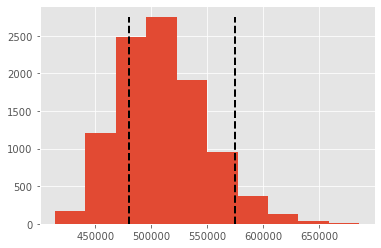

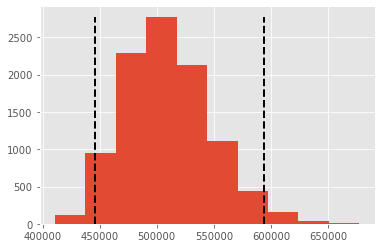

In [80]:
price_smpl = np.random.choice(df['price'],replace=False, size=100)
stud_test = test_class.studentized_bootstrap(price_smpl)
perc_test = test_class.one_sample_bootstrap(price_smpl, statistic=np.mean)

In [81]:
%%time

test_cov_stud=[]
for n in range(4, 120, 2):
    testsmpl = [np.random.choice(df['price'],replace=False, size=n) for i in range(500)]
    testboot_stud = [test_class.studentized_bootstrap(i, plot_results=False, num_iterations=1000) for i in testsmpl]
    test_cov_stud.append(coverage(testboot_stud, theta))

Wall time: 45min 18s


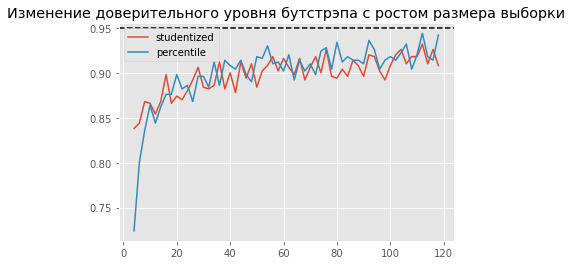

In [82]:

plt.plot(x, test_cov_stud, label='studentized')
plt.plot(x, test_cov, label='percentile')
plt.title('Изменение доверительного уровня бутстрэпа с ростом размера выборки')
#plt.xlabel('Размер выборки')
#plt.ylabel('Доверительная вероятность')
plt.axhline(0.95, linestyle='--', color='black')
plt.legend(loc='best')
plt.show()

Как мы видим (хоть и не супернаглядно), бутстрап Стьюдента показывает себя лучше при маленьких значениях выборки, однако достигается путем дополнительных вычислений, длительность которых увеличивается в разы, если у исследуемой статистики нет аналитического представления и мы вынуждены делать бутстрап второго уровня.

# Пуассоновский бутстрэп

Даже без студентизации бутстрэп все еще остается достаточно ресурсоемкой процедурой, что затрудняет его использование "в первозданном виде" на больших данных в проде. Кроме того, стандартный бутстрэп крайне тяжело параллелится, что, естественно, тоже не добавляет производительности. Чтобы понять, как умные ребята из гугла решили эту проблему, приглядимся к процедуре бутстрэпа повнимательнее. Ее суть заключается в том, что мы делаем некоторое кол-во ресэмплов из оригинальной выборки. Из этого очевидно, что каждое значение в каждом ресэмпле подчиняется биномиальному распределению с вероятностью выпадения 1/n, где n - размер ресэмпла. Тогда **кол-во попаданий каждого значения в ресэмпл** подчиняется мультиномиальному распределению с той же вероятностью.

Предположим, наша ориганальная выборка выглядит следующим образом: {10, 12, 15, 22}. Делаем бутстрэп с очень реалистичным кол-вом итераций, равным трем. Получаем следующие ресэмплы:

 - {10, 10, 22, 15}
 - {15, 15, 15, 12}
 - {12, 15, 22, 12}

Тогда кол-ва попаданий каждого значения в ресэмпл будут выглядет следующим образом:

- {2, 0, 1, 1}
- {0, 1, 3, 0}
- {0, 2, 1, 1}

Индексы сохраняем как в оригинальной выборке, т.е. первый массив читается следующим образом - 10 попало в ресэмпл два раза, 12 - 0 раз, 15 и 22 - по одному разу. Частота в мультиномальном законе будет равна 1/n, т.е. 1/4.

Поскольку $\large{\lim\limits_{n\to\infty}Binomial(n,\frac{1}{n})=Poisson(1)}$, мы можем просто просемплировать из Пуассоновского распределения кол-во попаданий каждого числа из оригинальной выборки в каждый бутстрэповский ресэмпл. Это работает только если n>100, но мы изначально и заваривали всю эту кашу исключительно с целью ускорить бутстрэп на больших данных. Результат в нашем примере будет выглядеть как-то так:

 - {2,0,1}
 - {0,0,0}
 - {2,0,3}
 - {0,4,0}

Несложно заметить, что если воспринимать это все как матрицу, то с т.з. размерности мы транспонировали предыдущую матрицу (теперь у нас 4 строки и 3 столбца). Первую строчку можно читать следующим образом: значение 10 2 раза попадает в первый ресэмпл, 0 раз во второй и 1 раз в третий. Огромный плюс такого "транспонированного" подхода заключается в том, что мы можем рассчитывать частотность для каждого значения независимо от остальных, а это значит, что все это дело можно распараллелить и получить кратный прирост скорости.

Возникает резонный вопрос - как из этого получить исходную статистику в случае больших данных? Они ведь потому и большие, что мы не можем запихнуть нашу исходную выборку в память и получаем данные стримингом. В то же рвемя, чтобы посчитать, например, среднее, нам нужны все значения для каждого прохода бутстрэпа. Получается, мы должны сначала насэмплировать из Пуассона частот для каждого значения из исходной выборки и только потом посчитать средние для каждой бутстрэп-итерации? Но где же в таком случае выигрыш - получается мы должны запихнуть в память всю выборку + частотность для каждого прохода, т.е. в памяти нужно хранить даже больше данных! 

Именно поэтому в реальности этот процесс проходит по-другому. Никто предварительно не рассчитывает частотность для каждого значения, чтобы потом брать среднее (или что мы там хотим посчитать). Вместо этого используется агрегат нарастающим итогом (rolling aggregate). Разберем, что это значит, чуть подробнее: 

1. Возьмем значение x1 из нашей первоначальной выборки, которую мы бутстрэпируем.
2. Получим из распределения Пуассона кол-во раз, которое это значение должно попасть в первую бутстрэп-выборку (W)
3. Обновим значение среднего (на первой итерации - ноль) по следующей формуле: $\large{\theta_n = \frac{\theta_{n-1}*w_{n-1}+x_n*W}{w_{n-1}+W}}$, где $\theta_{n-1}$ - среднее предыдущей итерации, $w_{n-1}$ - общее кол-во элементов в выборке по итогам предыдущих итераций, т.е. роллинг тотал всех предыдущих значений W.
4. Получим новое кол-во эл-тов в выборке, чтобы использовать его в роли $w_{n-1}$ в следующей итерации. Очевидно, что  $w_n=w_{n-1}+W$

В (практически псевдо) коде это выглядит как-то так:

In [14]:
rg = np.random.default_rng()
def update_mean(x_w_total:tuple, x_w:tuple) -> tuple:
    w_new = x_w_total[1] + x_w[1]
    x_new = ((x_w_total[0]*x_w_total[1]) + x_w[0]*x_w[1])/w_new
    return x_new, w_new

num_iterations = 10
streaming = [1,2,3,4,5,6,7]  #понятно дело, что в реальной жизни у нас нет такого контейнера, на то он и стриминг
x_w_total = [(streaming[0],1) for i in range(num_iterations)] #инициализируем среднее для каждого прохода бутстрэпа
boot_res = []
for i in streaming: #опять-таки, в реальной жизни это не два вложенных цикла а распараллеленные процессы, то бишь циклы для каждой i идут +- одновременно в разных процессах
    for j in range(num_iterations):
        w = rg.poisson(1,1)[0]
        x_w_total[j] = update_mean(x_w_total[j], (i,w))
print(x_w_total)

[(2.857142857142857, 7), (3.7142857142857144, 7), (3.4, 5), (2.2857142857142856, 7), (4.181818181818182, 11), (4.0, 9), (3.857142857142857, 7), (3.4545454545454546, 11), (4.0, 8), (3.4285714285714284, 7)]
